In [1]:
!pip install torch torchvision --quiet
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.3 MB/s eta 0:00:00


In [2]:
# Imports
import gdown
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


In [3]:
url = 'https://drive.google.com/uc?id=1-ihpczYF7C1PCnyINdCFh67wFDgzKmf1'
output = 'model_weights.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-ihpczYF7C1PCnyINdCFh67wFDgzKmf1
From (redirected): https://drive.google.com/uc?id=1-ihpczYF7C1PCnyINdCFh67wFDgzKmf1&confirm=t&uuid=f8e1f144-af7e-4924-86a2-349398599e49
To: /content/model_weights.zip
100%|██████████| 127M/127M [00:02<00:00, 60.0MB/s]


'model_weights.zip'

In [4]:
!unzip model_weights.zip

Archive:  model_weights.zip
   creating: model_weights/
  inflating: model_weights/decoder.pth  
  inflating: model_weights/decoder_van_gogh.pth  
  inflating: model_weights/decoder_picasso.pth  
  inflating: model_weights/decoder_monet.pth  
  inflating: model_weights/vgg_normalised.pth  


In [5]:
url = 'https://drive.google.com/uc?id=1z_4YZHHJODXlqWcz5v4y7oHVDaAvwUdi'
output = 'test_images.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1z_4YZHHJODXlqWcz5v4y7oHVDaAvwUdi
To: /content/test_images.zip
100%|██████████| 1.83M/1.83M [00:00<00:00, 37.7MB/s]


'test_images.zip'

In [6]:
!unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
   creating: test_images/content/
  inflating: test_images/content/dancing.jpg  
  inflating: test_images/bot_interface.png  
   creating: test_images/style/
  inflating: test_images/style/picasso.jpg  
  inflating: test_images/style/van_gogh.jpg  
  inflating: test_images/style/monet.jpg  
  inflating: test_images/bot_transfer.png  
  inflating: test_images/bot_van_gogh.png  


In [7]:
# image io
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor()
])


def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image)

In [8]:
# adain_utils

def calc_mean_std(feat, eps=1e-5):
    """
    Calculate the channel-wise mean and standard deviation of a feature tensor.

    Args:
        feat (Tensor): Input tensor
        eps (float): Small constant to avoid division by zero.

    Returns:
        Mean and standard deviation tensors.
    """
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat):
    """
    Apply Adaptive Instance Normalization to content features using style features.

    Args:
        content_feat (Tensor): Content features
        style_feat (Tensor): Style features

    Returns:
        Tensor: Stylized feature tensor of the same shape as content_feat.
    """
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


def _calc_feat_flatten_mean_std(feat):
    """
    Flatten 3D feature map and compute per-channel mean and std.
    """
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    """
    Compute the matrix square root using SVD.
    """
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())


def coral(source, target):
    """
    Perform CORAL (Correlation Alignment) to match the color distribution of the source to the target.
    """

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = (source_f_norm_transfer *
                         target_f_std.expand_as(source_f_norm) +
                         target_f_mean.expand_as(source_f_norm))

    return source_f_transfer.view(source.size())


def style_transfer(vgg, decoder, content, style, alpha):
    """
    Perform neural style transfer using AdaIN.
    """
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)


def process_images(net, content, style, alpha, preserve_colors=False):
    """Perform style transfer on image bytes"""

    # Apply color preservation if needed
    if preserve_colors:
        style = coral(style, content)

    # Move to device and add batch dimension
    device = next(net.parameters()).device
    content = content.to(device).unsqueeze(0)
    style = style.to(device).unsqueeze(0)

    # Perform style transfer
    with torch.no_grad():
        output = style_transfer(
            net.encode,
            net.decoder,
            content,
            style,
            alpha=alpha
        )

    # Convert to PIL image
    output = output.clamp(0, 1)
    return transforms.ToPILImage()(output.squeeze(0).cpu())



In [9]:
# adain_net


class Decoder(nn.Module):
    """
    Decoder network used to reconstruct an image from AdaIN features.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, (3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, (3, 3)),
        )

    def forward(self, x):
        return self.model(x)


class VGG(nn.Module):
    """
    Modified VGG-19 encoder used to extract content and style features.
    Includes convolutional layers up to relu4_1. Extra layers are present but not used.
    """
    def __init__(self):
        super(VGG, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  # relu1-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  # relu1-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  # relu2-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  # relu2-2
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  # relu3-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  # relu3-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu4-4
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-1
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-2
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  # relu5-3
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  # relu5-4
        )

    def forward(self, x):
        return self.model(x)


class Net(nn.Module):
    """
    Style transfer network combining a fixed VGG encoder and a trainable decoder.
    """
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        """
        Extract intermediate features (relu1_1 to relu4_1) from the input image.

        Returns:
            List of feature maps at different VGG depths.
        """
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        """
        Encode input image to relu4_1 feature map using the VGG encoder.

        Returns:
            Feature map after relu4_1.
        """
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        """
        Compute content loss as MSE between generated and target feature maps.

        Returns:
            Scalar content loss.
        """
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        """
        Compute style loss as the sum of MSE between mean and std of input and target.

        Returns:
            Scalar style loss.
        """
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return (self.mse_loss(input_mean, target_mean) +
                self.mse_loss(input_std, target_std))

    def forward(self, content, style, alpha=1.0):
        """
        Perform forward pass of the style transfer network.

        Args:
            content: content image tensor
            style: style image tensor
            alpha: interpolation factor between content and style features (0 to 1)

        Returns:
            Content loss and total style loss
        """
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s


In [10]:
# functional
def init_model():
    """Initialize and load style transfer model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using GPU:", torch.cuda.is_available())
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
    decoder = Decoder()
    vgg = VGG()

    # Load weights
    decoder.load_state_dict(torch.load('model_weights/decoder.pth', map_location=device))
    vgg.model.load_state_dict(torch.load('model_weights/vgg_normalised.pth', map_location=device))

    # Configure models
    vgg = nn.Sequential(*list(vgg.model.children())[:31])
    vgg.to(device).eval()
    decoder.to(device).eval()

    decoder_picasso = Decoder()
    decoder_van_gogh = Decoder()
    decoder_monet = Decoder()

    # Load weights for fine-tuned models
    decoder_picasso.load_state_dict(torch.load('model_weights/decoder_picasso.pth', map_location=device))
    decoder_van_gogh.load_state_dict(torch.load('model_weights/decoder_van_gogh.pth', map_location=device))
    decoder_monet.load_state_dict(torch.load('model_weights/decoder_monet.pth', map_location=device))

    decoder_picasso.to(device).eval()
    decoder_van_gogh.to(device).eval()
    decoder_monet.to(device).eval()

    return (Net(vgg, decoder).to(device).eval(), Net(vgg, decoder_picasso).to(device).eval(),
            Net(vgg, decoder_van_gogh).to(device).eval(), Net(vgg, decoder_monet).to(device).eval())



In [11]:
net, net_picasso, net_van_gogh, net_monet = init_model()

Using GPU: False
GPU name: None


In [12]:
content_image = load_image('test_images/content/dancing.jpg')
style_monet = load_image('test_images/style/monet.jpg')
style_picasso = load_image('test_images/style/picasso.jpg')
style_van_gogh = load_image('test_images/style/van_gogh.jpg')

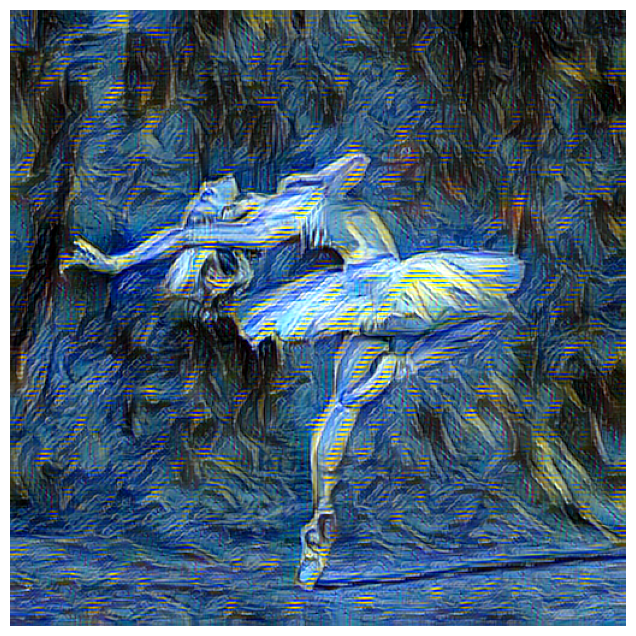

In [13]:
result_image = process_images(net_van_gogh, content_image, style_van_gogh, alpha=1.0)

plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()

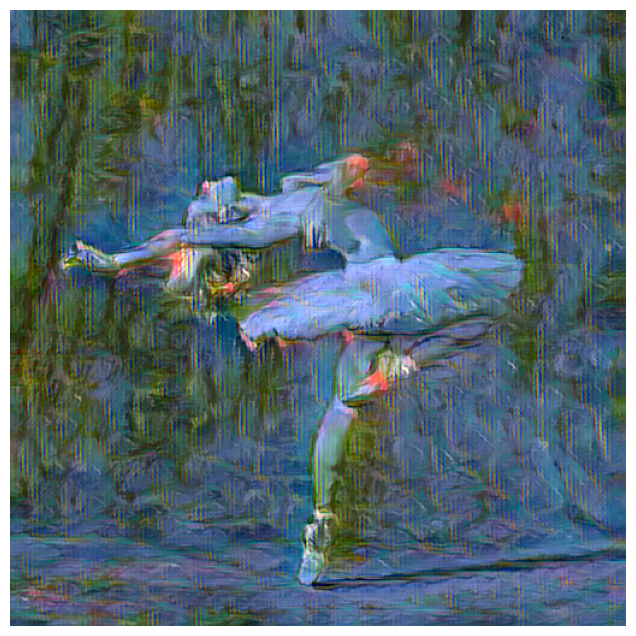

In [14]:
result_image = process_images(net_monet, content_image, style_monet, alpha=1.0)

plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()

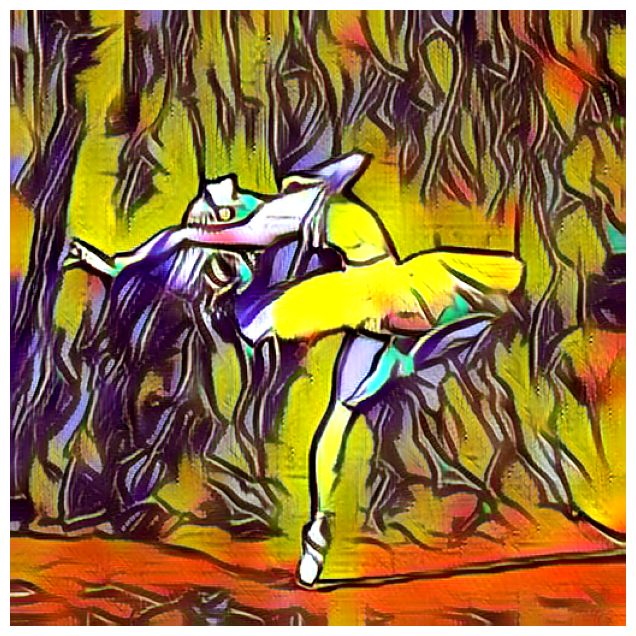

In [15]:
result_image = process_images(net_picasso, content_image, style_picasso, alpha=1.0)

plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()

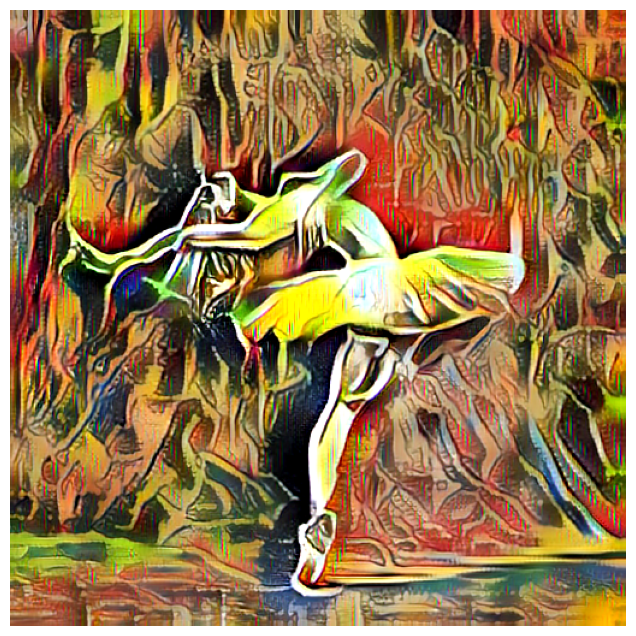

In [16]:
result_image = process_images(net, content_image, style_picasso, alpha=1.0)

plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()